## 第8章 计算机视觉
### 8.1 图像增广

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import d2lzh as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

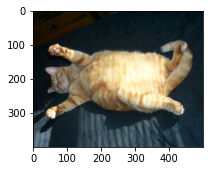

In [2]:
d2l.set_figsize()
img = Image.open('data/cat1.jpg')
d2l.plt.imshow(img)

In [3]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols+j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows*num_cols)]
    show_images(Y, num_rows, num_cols, scale)

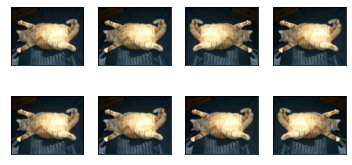

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

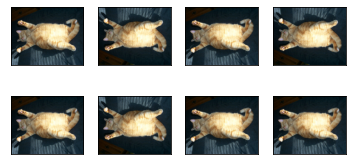

In [6]:
apply(img, torchvision.transforms.RandomVerticalFlip())

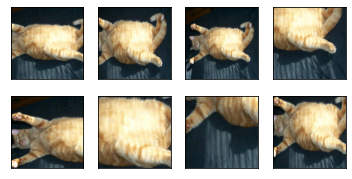

In [7]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

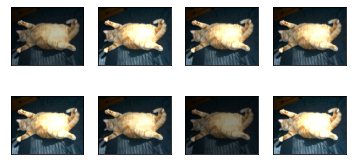

In [8]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

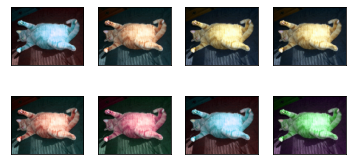

In [9]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

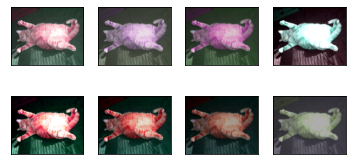

In [10]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

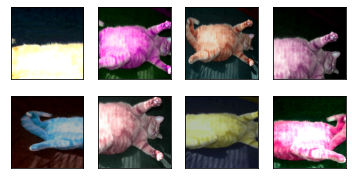

In [11]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug
])
apply(img, augs)

Files already downloaded and verified


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

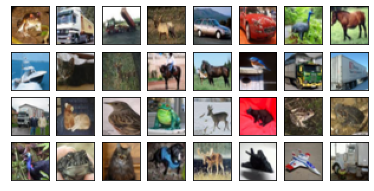

In [12]:
all_imgs = torchvision.datasets.CIFAR10(train=True, root='data/CIFAR-10', download=True)
show_images([all_imgs[i][0] for i in range(32)], 4, 8, scale=0.8)

In [13]:
flip_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor()
])
no_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [14]:
import sys
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root='data/CIFAR-10'):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [15]:
import time
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net = net.cuda()
    print("training on", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1)==y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' % (epoch+1, train_l_sum/batch_count, train_acc_sum/n, test_acc, time.time()-start))

In [16]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)

In [17]:
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
Let's use 2 GPUs!
training on cuda
epoch 1, loss 1.3684, train acc 0.504, test acc 0.498, time 23.6 sec
epoch 2, loss 0.4995, train acc 0.646, test acc 0.622, time 17.8 sec
epoch 3, loss 0.2813, train acc 0.705, test acc 0.644, time 18.0 sec
epoch 4, loss 0.1871, train acc 0.737, test acc 0.638, time 18.2 sec
epoch 5, loss 0.1337, train acc 0.768, test acc 0.670, time 17.8 sec
epoch 6, loss 0.1015, train acc 0.788, test acc 0.713, time 18.2 sec
epoch 7, loss 0.0794, train acc 0.807, test acc 0.672, time 17.8 sec
epoch 8, loss 0.0630, train acc 0.825, test acc 0.702, time 17.7 sec
epoch 9, loss 0.0511, train acc 0.839, test acc 0.763, time 17.8 sec
epoch 10, loss 0.0419, train acc 0.855, test acc 0.766, time 17.9 sec


### 8.2 微调

In [18]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os
import sys
import d2lzh as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
data_dir = 'data'
# 列出指定路径下的文件夹名称
os.listdir(os.path.join(data_dir, 'hotdog'))

['train', 'test']

In [20]:
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

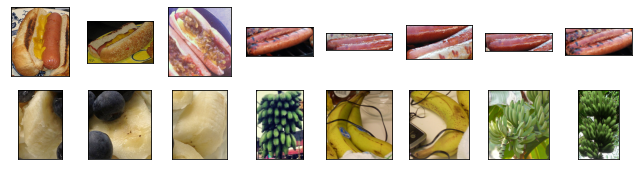

In [21]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs, 2, 8, scale=1.4)

In [22]:
# 指定RGB三个通道的均值和方差来将图像通道归一化
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406], 
    std = [0.229, 0.224, 0.225]
)
train_augs = transforms.Compose([
    # 统一大小
    transforms.RandomResizedCrop(size=224), 
    # 水平翻转
    transforms.RandomHorizontalFlip(), 
    # 值域0到1之间
    transforms.ToTensor(), 
    # 标准化
    normalize
])
test_augs = transforms.Compose([
    transforms.Resize(size=256), 
    # 中心裁剪
    transforms.CenterCrop(size=224), 
    transforms.ToTensor(), 
    normalize
])

In [23]:
pretrained_net = models.resnet18(pretrained=True)

In [24]:
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [25]:
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


In [26]:
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())
lr = 0.01
optimizer = optim.SGD([
    {'params': feature_params}, 
    {'params': pretrained_net.fc.parameters(), 'lr': lr*10}
], lr=lr, weight_decay=0.001)

In [27]:
def train_fine_tining(net, optimizer, batch_size=128, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs), batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs), batch_size)
    loss = torch.nn.CrossEntropyLoss()
    d2l.train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [28]:
train_fine_tining(pretrained_net, optimizer)

Let's use 2 GPUs!
training on cuda
epoch 1, loss 3.3977, train acc 0.690, test acc 0.924, time 43.1 sec
epoch 2, loss 0.2654, train acc 0.869, test acc 0.912, time 42.4 sec
epoch 3, loss 0.0814, train acc 0.927, test acc 0.924, time 42.1 sec
epoch 4, loss 0.0860, train acc 0.900, test acc 0.786, time 45.3 sec
epoch 5, loss 0.0587, train acc 0.920, test acc 0.882, time 43.1 sec


In [29]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tining(scratch_net, optimizer)

Let's use 2 GPUs!
training on cuda
epoch 1, loss 2.5829, train acc 0.585, test acc 0.575, time 42.8 sec
epoch 2, loss 0.3181, train acc 0.769, test acc 0.733, time 43.1 sec
epoch 3, loss 0.1535, train acc 0.818, test acc 0.792, time 45.7 sec
epoch 4, loss 0.1161, train acc 0.805, test acc 0.819, time 49.1 sec
epoch 5, loss 0.1045, train acc 0.783, test acc 0.781, time 45.0 sec


### 8.3 目标检测和边界框

In [30]:
import d2lzh as d2l
from PIL import Image

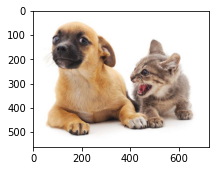

In [31]:
d2l.set_figsize()
img = Image.open('data/catdog.jpg')
d2l.plt.imshow(img);

In [32]:
# bbox是bounding box的缩写
# [左上角x,左上角y,右下角x,右下角y]
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 114, 655, 493]

In [33]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式
    # 转换成matplotlib格式：((左上x, 左上y), 宽, 高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1], 
        fill=False, edgecolor=color, linewidth=2
    )

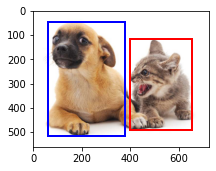

In [34]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'));
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

### 8.4 锚框

In [35]:
import numpy as np
import math
import torch
import d2lzh as d2l
from PIL import Image

In [36]:
d2l.set_figsize()
img = Image.open('data/catdog.jpg')
w, h = img.size
print('w = %d, h = %d' % (w, h))
def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    # 目标图像的高、宽
    h, w = feature_map.shape[-2:]
    # 记录锚框面积和宽高比的组合方式
    pairs = []
    # 包含s1或r1的组合方式
    for r in ratios:
        pairs.append([sizes[0], math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s, math.sqrt(ratios[0])])
    pairs = np.array(pairs)
    # size * sqrt(h*w*ration)
    ss1 = pairs[:, 0] * math.sqrt(1) * pairs[:, 1]
    # size / sqrt(h*w/ration)
    ss2 = pairs[:, 0] * math.sqrt(1) / (pairs[:, 1])
    # 锚框左上角、右下角坐标计算
    # 除以2是因为像素点在锚框中心位置
    base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2
    # 归一化x轴
    shifts_x = np.arange(0, w) / w
    # 归一化y轴
    shifts_y = np.arange(0, h) / h
    # 生成图布内所有坐标点
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    # 拉成1维，位置相同的元素组成画布内的一个点的表示
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)
    # 每个像素点添加所有类型的锚框
    anchors = shifts.reshape((-1, 1, 4))+base_anchors.reshape((1, -1, 4))
    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)
# [batch_size, channel, hight, width]
X = torch.Tensor(1, 3, h, w)
Y = MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
# Y = d2l.MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

w = 728, h = 561


torch.Size([1, 2042040, 4])

In [37]:
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, 0, :]

tensor([-0.0316,  0.0706,  0.7184,  0.8206])

In [38]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    # 获取锚框上的标签
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    # 框的颜色
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color=='w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], 
                     va='center', ha='center', fontsize=6, color=text_color, 
                     bbox=dict(facecolor=color, lw=0))
    # d2l.plt.savefig('1.jpg')

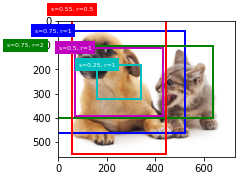

In [39]:
d2l.set_figsize()
fig = d2l.plt.imshow(img)
bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
show_bboxes(fig.axes, boxes[250, 250, :, :]*bbox_scale, 
           ['s=0.75, r=1', 's=0.75, r=2', 's=0.55, r=0.5', 's=0.5, r=1', 's=0.25, r=1'])

In [40]:
# 参考https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py#L356
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    # 左上角取最大
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    # 右下角取最小
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

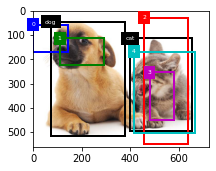

In [41]:
bbox_scale = torch.tensor(
    (w, h, w, h), dtype=torch.float32)
ground_truth = torch.tensor([
    [0, 0.1, 0.08, 0.52, 0.92], 
    [1, 0.55, 0.2, 0.9, 0.88]
])
anchors = torch.tensor([
    [0, 0.1, 0.2, 0.3], 
    [0.15, 0.2, 0.4, 0.4], 
    [0.63, 0.05, 0.88, 0.98], 
    [0.66, 0.45, 0.8, 0.8], 
    [0.57, 0.3, 0.92, 0.9]
])
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:]*bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors*bbox_scale, ['0', '1', '2', '3', '4']);

In [42]:
def match_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    # 为与真实边框最相似的锚框分配label
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 对于第i个锚框与第j个真实边框，我们用矩阵第i行，第j列的元素表示其二者的IoU
    jaccard = compute_jaccard(anchors, ground_truth)
    # 初始化一个张量用于存储每一个锚框对应的真实边框
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    # 根据阈值为锚框分配真实边框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious>=0.5).reshape(-1)
    box_j = indices[max_ious>=0.5]
    anchors_bbox_map[anc_i] = box_j
    # 为每一个锚框匹配最大的iou对应的真实边框
    anc_i = torch.argmax(jaccard, dim=0)
    box_j = torch.arange(num_gt_boxes, device=device)
    anchors_bbox_map[anc_i] = box_j
    return anchors_bbox_map
def box_corner_to_center(boxes):
    # 将(左上角坐标, 右下角坐标)转换为(中心点坐标, 宽, 长)
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = np.stack((cx, cy, w, h), axis=1)
    return boxes
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    # 为锚框标注偏移量
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * np.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = np.concatenate([offset_xy, offset_wh], axis=1)
    return offset

In [43]:
def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        # 取当前边框的标签
        label = labels[i, :, :]
        # 第一列为标签
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors, device)
        # 只保留匹配上的，未匹配的为-1被过滤了
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 初始化锚框标签
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        # 初始化偏移量
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        # 为锚框标记类别
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        # 加1为了使原来的背景变为标签0
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 计算偏移量,没有匹配上就是4个0
        offset = torch.from_numpy(offset_boxes(anchors, assigned_bb)) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [44]:
labels = multibox_target(anchors.unsqueeze(dim=0), 
                        ground_truth.unsqueeze(dim=0))

In [45]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [46]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [47]:
labels[0]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
          1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]])

In [48]:
# 将(中心点坐标, 宽, 长)转换为(左上角坐标, 右下角坐标)
def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = np.stack((x1, y1, x2, y2), axis=1)
    return boxes
# 根据锚框和偏移量反推预测的边框
def offset_inverse(anchors, offset_preds):
    c_anc = torch.from_numpy(box_corner_to_center(anchors))
    c_pred_bb_xy = (offset_preds[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    c_pred_bb_wh = np.exp(offset_preds[:, 2:] / 5) * c_anc[:, 2:]
    c_pred_bb = np.concatenate([c_pred_bb_xy, c_pred_bb_wh], axis=1)
    predicted_bb = box_center_to_corner(c_pred_bb)
    return predicted_bb

In [49]:
def nms(boxes, scores, iou_threshold):
    boxes = torch.tensor(boxes)
    # 降序排列，并返回索引
    B = torch.argsort(scores, dim=-1, descending=True)
    # 保存保留框的索引
    keep = []
    while B.numel() > 0:
        # 最大值的索引
        i = B[0]
        keep.append(i)
        # 终止条件，1个框无法计算交并比
        if B.numel() == 1:
            break
        # 当前框与剩余框的交并比
        iou = compute_jaccard(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        # 筛选满足条件的框，返回其索引
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        # 加1是因为当前框已经计算过，所以整体索引加1才是剩余框的索引
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [50]:
anchors = torch.tensor([
    [0.1, 0.08, 0.52, 0.92], 
    [0.08, 0.2, 0.56, 0.95], 
    [0.15, 0.3, 0.62, 0.91], 
    [0.55, 0.2, 0.9, 0.88]
])
offset_preds = torch.tensor([0.0]*(4*len(anchors)))
cls_probs = torch.tensor([
    [0., 0., 0., 0.],      # 背景的预测概率
    [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
    [0.1, 0.2, 0.3, 0.9]   # 猫的预测概率
])

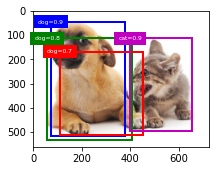

In [51]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors*bbox_scale, 
           ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [52]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, score_threshold=0.0099):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        # 每一列最大值极其索引，且过滤掉背景概率
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, 0.5)
        # 将所有未保留的框设为背景类
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        # 不重复元素（类别），不重复元素的个数（类别数）
        uniques, counts = combined.unique(return_counts=True)
        # 剔除掉只出现过1次的索引
        non_keep = uniques[counts==1]
        all_id_sorted = torch.cat((keep, non_keep))
        # 设为背景
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        predicted_bb = torch.tensor(predicted_bb, device=device)
        pred_info = torch.cat(
            (class_id.unsqueeze(1).float(), 
            conf[all_id_sorted].unsqueeze(1), 
            predicted_bb[all_id_sorted]), dim=1
        )
        out.append(pred_info)
    return torch.stack(out)

In [53]:
output = multibox_detection(
    cls_probs.unsqueeze(dim=0), 
    offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0), 
    nms_threshold=0.5
)
output

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])

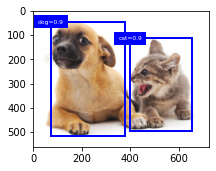

In [54]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().cpu().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:])*bbox_scale], label)

### 8.5 多尺度目标检测

In [55]:
from PIL import Image
img = Image.open('data/catdog.jpg')
w, h = img.size
print(w, h)

728 561


In [56]:
import d2lzh as d2l
import torch
def display_anchors(fmap_w, fmap_h, s):
    # batch_size, channels, high, width
    fmap = torch.zeros((1, 10, fmap_h, fmap_w), dtype=torch.float32)
    # 归一化
    offset_x, offset_y = 1.0/fmap_w, 1.0/fmap_h
    # 平移所有锚框使均匀分布在图片上
    anchors = d2l.MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5])
    anchors += torch.tensor([offset_x/2, offset_y/2, offset_x/2, offset_y/2])
    bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0]*bbox_scale)

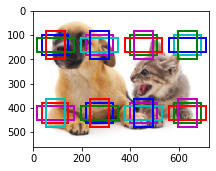

In [57]:
display_anchors(fmap_w=4, fmap_h=2, s=[0.15])

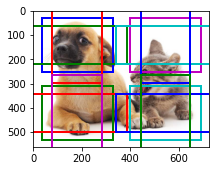

In [58]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

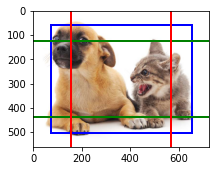

In [59]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

### 8.6 目标检测数据集（皮卡丘）

In [60]:
import os
import json
import numpy as np
import torch
import torchvision
from PIL import Image
import sys
data_dir = 'data/pikachu'

In [61]:
# 对皮卡丘数据进行读取，并保存为指定格式
class PiKachuDetDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, part, image_size=(256, 256)):
        assert part in ['train', 'val']
        # 图片尺寸
        self.image_size = image_size
        # 图片路径
        self.image_dir = os.path.join(data_dir, part, 'images')
        # 图片标签
        with open(os.path.join(data_dir, part, 'label.json')) as f:
            self.label = json.load(f)
        self.transform = torchvision.transforms.Compose([
            # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
            torchvision.transforms.ToTensor()
        ])
    def __len__(self):
        # 样本个数
        return len(self.label)
    def __getitem__(self, index):
        # 构建样本
        image_path = str(index+1)+'.png'
        cls = self.label[image_path]['class']
        label = np.array([cls]+self.label[image_path]['loc'], dtype='float32')[None, :]
        PIL_img = Image.open(os.path.join(self.image_dir, image_path)).convert('RGB').resize(self.image_size)
        img = self.transform(PIL_img)
        sample = {
            # shape: (1, 5) [class, xmin, ymin, xmax, ymax]
            'label': label, 
            # shape: (3, *image_size)
            'image': img
        }
        return sample

In [62]:
def load_data_pikachu(batch_size, edge_size=256, data_dir='data/pikachu'):
    # edge_size：输出图像的宽和高
    image_size = (edge_size, edge_size)
    train_dataset = PiKachuDetDataset(data_dir, 'train', image_size)
    val_dataset = PiKachuDetDataset(data_dir, 'val', image_size)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_iter, val_iter

In [63]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size, data_dir)
batch = iter(train_iter).next()
print(batch['image'].shape, batch['label'].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


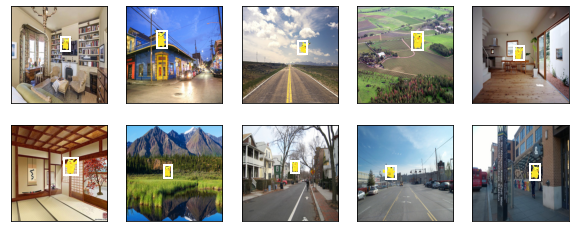

In [64]:
imgs = batch['image'][:10].permute(0, 2, 3, 1)
# 获取框的坐标
bboxes = batch['label'][:10, 0, 1:]
axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    d2l.show_bboxes(ax, [bb*edge_size], colors=['w'])

### 8.7 单发多框检测（SSD）

In [65]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return torch.nn.Conv2d(num_inputs, num_anchors*(num_classes+1), kernel_size=3, padding=1)

In [66]:
def bbox_predictor(num_inputs, num_anchors):
    return torch.nn.Conv2d(num_inputs, num_anchors*4, kernel_size=3, padding=1)

In [67]:
def forward(x, block):
    return block(x)
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
(Y1.shape, Y2.shape)

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [68]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [69]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [70]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(torch.nn.BatchNorm2d(out_channels))
        blk.append(torch.nn.ReLU())
        in_channels = out_channels
    blk.append(torch.nn.MaxPool2d(2))
    return torch.nn.Sequential(*blk)

In [71]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [72]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters)-1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return torch.nn.Sequential(*blk)
forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [73]:
def get_blk(i):
    if i==0:
        blk = base_net()
    elif i==1:
        blk = down_sample_blk(64, 128)
    elif i==4:
        blk = torch.nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [74]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [75]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
# 这里的计算参见8.4.1
num_anchors = len(sizes[0])+len(ratios[0])-1

In [76]:
class TinySSD(torch.nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # The assignment statement is self.blk_i = get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None]*5, [None]*5, [None]*5
        for i in range(5):
            # getattr(self, 'blk_%d' % i) accesses self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i], 
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}')
            )
        # In the reshape function, 0 indicates that the batch size remains
        # unchanged
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        # batch_size, num_anchors, num_classes
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes+1
        )
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [77]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [78]:
print(net)

TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

In [79]:
batch_size = 32
train_iter, _ = load_data_pikachu(batch_size)

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [81]:
cls_loss = torch.nn.CrossEntropyLoss(reduction='none')
bbox_loss = torch.nn.L1Loss(reduction='none')
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), 
                  cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds*bbox_masks, 
                    bbox_labels*bbox_masks).mean(dim=1)
    return cls+bbox

In [82]:
def cls_eval(cls_preds, cls_labels):
    # Because the category prediction results are placed in the final
    # dimension, argmax must specify this dimension
    return float(
        (cls_preds.argmax(dim=-1).type(
            cls_labels.dtype
        )==cls_labels).sum()
    )
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels-bbox_preds)*bbox_masks)).sum())

In [83]:
import time
num_epochs = 30
net = net.to(device)
for epoch in range(num_epochs):
    accuracy_sum = 0
    mae_sum = 0
    num_examples = 0
    num_labels = 0
    net.train()
    for data in train_iter:
        features = data['image']
        target = data['label']
        begin = time.time()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y.cpu())
        bbox_labels, bbox_masks, cls_labels = bbox_labels.to(device), bbox_masks.to(device), cls_labels.to(device)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        accuracy_sum += cls_eval(cls_preds, cls_labels)
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        num_examples += bbox_labels.numel()
        num_labels += cls_labels.numel()
    cls_err, bbox_mae = 1-accuracy_sum/num_labels, mae_sum/num_examples
    if (epoch+1) % 5==0:
        print(f'epoch {epoch+1}, class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}, time {time.time()-begin:.1f} sec')

epoch 5, class err 3.90e-04, bbox mae 5.44e-04, time 0.4 sec
epoch 10, class err 3.90e-04, bbox mae 5.21e-04, time 0.2 sec
epoch 15, class err 3.90e-04, bbox mae 4.99e-04, time 0.3 sec
epoch 20, class err 3.90e-04, bbox mae 4.74e-04, time 0.3 sec
epoch 25, class err 3.90e-04, bbox mae 4.45e-04, time 0.4 sec
epoch 30, class err 3.90e-04, bbox mae 4.11e-04, time 0.3 sec


In [84]:
from copy import deepcopy
img = Image.open('data/pikachu.jpg')
img = np.array(img, dtype=np.float32) / 255.0
X = torch.from_numpy(img)
# [batch_size, 3, image_height, image_width]  ([B, C, H, W])
show_img = deepcopy(X*255.0)
X = X.permute(2, 0, 1).unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

show_img = show_img.permute(2, 0, 1).unsqueeze(0).float()
show_img = show_img.squeeze(0).permute(1, 2, 0).long()

In [85]:
img.shape

torch.Size([512, 512, 3])

In [86]:
import torch.nn.functional as F
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs.detach().cpu(), bbox_preds.detach().cpu(), anchors.detach().cpu())
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]
output = predict(X)

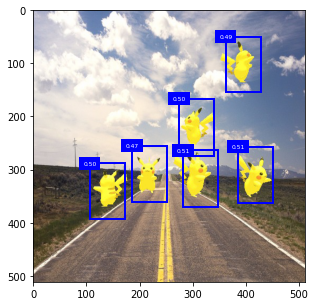

In [89]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device).float()]
        show_bboxes(fig.axes, bbox, '%.2f' % score)
        d2l.plt.savefig('1.jpg')
display(show_img, output.cpu(), threshold=0.46)

### 8.8 区域卷积神经网络（R-CNN）

In [90]:
import torch
import torchvision
X = torch.arange(16, dtype=torch.float).view(1, 1, 4, 4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [91]:
rois = torch.tensor([
    [0, 0, 0, 20, 20], 
    [0, 0, 10, 30, 30]
], dtype=torch.float)

In [92]:
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

tensor([[[[ 5.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

### 8.9 语义分割和数据集

In [1]:
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm
import sys
import d2lzh as d2l

In [2]:
! ls data/VOCdevkit/VOC2012

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [3]:
def read_voc_images(root='data/VOCdevkit/VOC2012', is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt'
    )
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    if max_num is not None:
        images = images[:min(max_num, len(images))]
    features, labels = [None]*len(images), [None]*len(images)
    for i, fname in tqdm(enumerate(images)):
        features[i] = Image.open('%s/JPEGImages/%s.jpg' % (root, fname)).convert('RGB')
        labels[i] = Image.open('%s/SegmentationClass/%s.png' % (root, fname)).convert('RGB')
    return features, labels
voc_dir = 'data/VOCdevkit/VOC2012'
train_features, train_labels = read_voc_images(voc_dir, max_num=100)

100it [00:01, 93.01it/s]


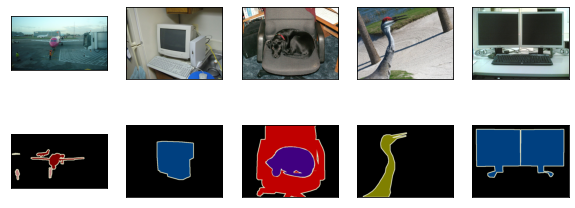

In [4]:
n = 5
imgs = train_features[:n]+train_labels[:n]
d2l.show_images(imgs, 2, n);

In [5]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
colormap2label = torch.zeros(256**3, dtype=torch.uint8)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0]*256+colormap[1])*256+colormap[2]] = i
def voc_label_indices(colormap, colormap2label):
    """
    将colormap(PIL)转换为colormap2label(uint8)
    """
    colormap = np.array(colormap.convert('RGB')).astype('int32')
    idx = ((colormap[:, :, 0]*256+colormap[:, :, 1])*256+colormap[:, :, 2])
    return colormap2label[idx]

In [7]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=torch.uint8),
 'aeroplane')

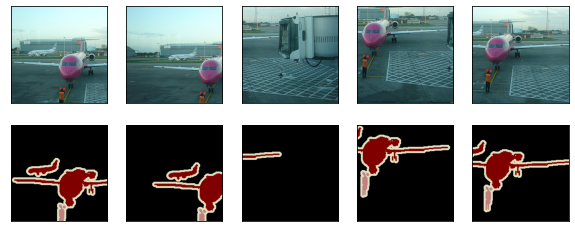

In [8]:
def voc_rand_crop(feature, label, height, width):
    """
    同时对图片和标签进行随机裁剪为固定大小
    """
    i, j, h, w = torchvision.transforms.RandomCrop.get_params(
        feature, output_size=(height, width)
    )
    feature = torchvision.transforms.functional.crop(feature, i, j, h, w)
    label = torchvision.transforms.functional.crop(label, i, j, h, w)
    return feature, label
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 200)
d2l.show_images(imgs[::2]+imgs[1::2], 2, n);

In [9]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label, max_num=None):
        # crop_size - 随机裁剪后的大小
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.tsf = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(), 
            torchvision.transforms.Normalize(mean=self.rgb_mean, 
                                            std=self.rgb_std)
        ])
        self.crop_size = crop_size #(h, w)
        features, labels = read_voc_images(root=voc_dir, 
                                          is_train=is_train, 
                                          max_num=max_num)
        self.features = self.filter(features)
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' valid examples')
    def filter(self, imgs):
        return [img for img in imgs if (
            img.size[1] >= self.crop_size[0] and
            img.size[0] >= self.crop_size[1]
        )]
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        # float32, uint8
        return (self.tsf(feature), voc_label_indices(label, self.colormap2label))
    def __len__(self):
        return len(self.features)

In [10]:
crop_size = (320, 480)
max_num = 100
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label, max_num)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label, max_num)

100it [00:01, 93.78it/s]
12it [00:00, 109.42it/s]

read 75 valid examples


100it [00:01, 93.63it/s]

read 77 valid examples


In [11]:
batch_size = 64
num_works = 0 if sys.platform.startswith('win32') else 4
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, drop_last=True, num_workers=num_works)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True, num_workers=num_works)

In [12]:
for X, Y in train_iter:
    print(X.dtype, X.shape)
    print(Y.dtype, Y.shape)
    break

torch.float32 torch.Size([64, 3, 320, 480])
torch.uint8 torch.Size([64, 320, 480])


### 8.10 全卷积网络（FCN）

In [13]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import d2lzh as d2l

In [14]:
X = torch.arange(1, 17).view((1, 1, 4, 4)).float()
K = torch.arange(1, 10).view((1, 1, 3, 3)).float()
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
conv.load_state_dict({'weight': K})
conv(X), K

(tensor([[[[348., 393.],
           [528., 573.]]]], grad_fn=<MkldnnConvolutionBackward>),
 tensor([[[[1., 2., 3.],
           [4., 5., 6.],
           [7., 8., 9.]]]]))

In [15]:
W, k = torch.zeros((4, 16)), torch.zeros(11)
k[:3], k[4:7], k[8:] = K[0, 0, 0, :], K[0, 0, 1, :], K[0, 0, 2, :]
W[0, 0:11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k
torch.mm(W, X.view((16, 1))).view((1, 1, 2, 2)), W

(tensor([[[[348., 393.],
           [528., 573.]]]]),
 tensor([[1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0., 0.],
         [0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0.],
         [0., 0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9.]]))

In [16]:
X = torch.zeros((1, 3, 64, 64))
conv = torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=4, padding=1, stride=2)
Y = conv(X)
Y.shape

torch.Size([1, 10, 32, 32])

In [17]:
conv_trans = torch.nn.ConvTranspose2d(in_channels=10, out_channels=3, kernel_size=4, padding=1, stride=2)
conv_trans(Y).shape

torch.Size([1, 3, 64, 64])

In [18]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.layer4[1], pretrained_net.avgpool, pretrained_net.fc

(BasicBlock(
   (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace)
   (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True))

In [19]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [20]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [21]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))

In [22]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size+1)//2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1), 
         torch.arange(kernel_size).reshape(1, -1))
    filt = (1-torch.abs(og[0] - center) / factor) * (1-torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, 
                         kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt.float()
    return weight

In [23]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [24]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('data/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


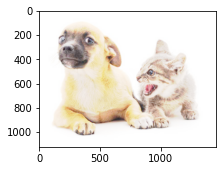

In [25]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In [26]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);
torch.nn.init.xavier_uniform_(net.final_conv.weight.data);

In [27]:
crop_size = (320, 480)
batch_size = 32
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label)
num_works = 0 if sys.platform.startswith('win32') else 4
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, drop_last=True, num_workers=num_works)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True, num_workers=num_works)

1464it [00:17, 82.77it/s]
10it [00:00, 92.92it/s]

read 1114 valid examples


1449it [00:17, 82.37it/s]

read 1078 valid examples


In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def loss(inputs, targets):
    loss_calc = F.cross_entropy(inputs, targets.long(), reduction='none').mean()
    return loss_calc
num_epochs, lr, wd, devices = 10, 0.003, 1e-3, device
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch8(train_iter, test_iter, net, loss, trainer, device, num_epochs)

Let's use 2 GPUs!
training on cuda
epoch 1, loss 0.4443, train acc 0.869, test acc 0.822, time 16.7 sec
epoch 2, loss 0.2201, train acc 0.870, test acc 0.826, time 16.4 sec
epoch 3, loss 0.1441, train acc 0.872, test acc 0.825, time 16.5 sec
epoch 4, loss 0.1043, train acc 0.876, test acc 0.827, time 16.7 sec
epoch 5, loss 0.0834, train acc 0.876, test acc 0.826, time 16.5 sec
epoch 6, loss 0.0699, train acc 0.876, test acc 0.829, time 16.7 sec
epoch 7, loss 0.0593, train acc 0.876, test acc 0.827, time 16.7 sec
epoch 8, loss 0.0502, train acc 0.879, test acc 0.829, time 16.4 sec
epoch 9, loss 0.0445, train acc 0.879, test acc 0.827, time 16.7 sec
epoch 10, loss 0.0402, train acc 0.878, test acc 0.828, time 16.7 sec


In [54]:
def predict(img):
    
    rgb_mean = np.array([0.485, 0.456, 0.406])
    rgb_std = np.array([0.229, 0.224, 0.225])
    tsf = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(mean=rgb_mean, 
                                        std=rgb_std)
    ])
    X = np.array(img)/255.0
    X = torch.from_numpy(X).unsqueeze(0).permute(0, 3, 1, 2).float()
    # X = tsf(img).unsqueeze(0)
    pred = net(X.to(device)).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [55]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=device)
    X = pred.long()
    return colormap[X, :]

1449it [00:16, 86.29it/s]


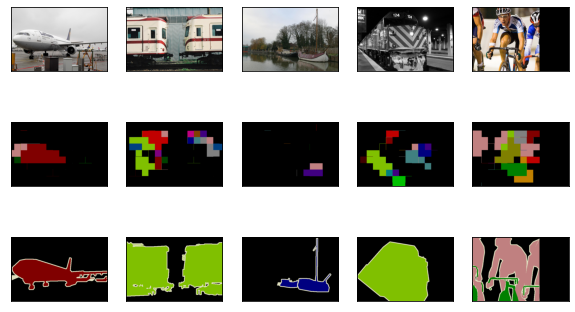

In [56]:
test_images, test_labels = d2l.read_voc_images(is_train=False)
n, imgs = 5, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [torch.from_numpy(np.array(X)), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3]+imgs[1::3]+imgs[2::3], 3, n, scale=2);

### 8.11 样式迁移

In [1]:
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
import sys
import d2lzh as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

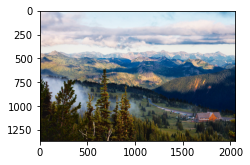

In [2]:
d2l.set_figsize()
content_img = Image.open('data/rainier.jpg')
d2l.plt.imshow(content_img);

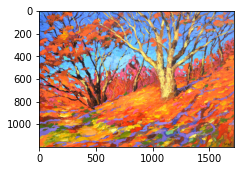

In [3]:
d2l.set_figsize()
style_img = Image.open('data/autumn_oak.jpg')
d2l.plt.imshow(style_img);

In [4]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])
def preprocess(PIL_img, image_shape):
    process = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape), 
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    # (batch_size, 3, H, W)
    return process(PIL_img).unsqueeze(dim=0)
def postprocess(img_tensor):
    inv_normalize = torchvision.transforms.Normalize(
        mean = -rgb_mean/rgb_std, 
        std = 1/rgb_std
    )
    to_PIL_image = torchvision.transforms.ToPILImage()
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0, 1))

In [5]:
pretrained_net = torchvision.models.vgg19(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/wzy/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [01:58<00:00, 4831852.59it/s]


In [6]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [7]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [8]:
net_list = []
for i in range(max(content_layers+style_layers)+1):
    net_list.append(pretrained_net.features[i])
net = torch.nn.Sequential(*net_list)

In [9]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [10]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y
def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [11]:
def content_loss(Y_hat, Y):
    return F.mse_loss(Y_hat, Y)

In [12]:
def gram(X):
    num_channels, n = X.shape[1], X.shape[2]*X.shape[3]
    X = X.view(num_channels, n)
    return torch.matmul(X, X.t())/(num_channels*n)

In [13]:
def style_loss(Y_hat, gram_Y):
    return F.mse_loss(gram(Y_hat), gram_Y)

In [14]:
def tv_loss(Y_hat):
    return 0.5*(F.l1_loss(Y_hat[:,:,1:,:], Y_hat[:,:,:-1,:])+
               F.l1_loss(Y_hat[:,:,:,1:], Y_hat[:,:,:,:-1]))

In [15]:
content_weight, style_weight, tv_weight = 1, 1e3, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y)*content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y)*style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X)*tv_weight
    # 对所有损失求和
    l = sum(styles_l)+sum(contents_l)+tv_l
    return contents_l, styles_l, tv_l, l

In [16]:
class GeneratedImage(torch.nn.Module):
    def __init__(self, img_shape):
        super(GeneratedImage, self).__init__()
        self.weight = torch.nn.Parameter(torch.rand(*img_shape))
    def forward(self):
        return self.weight

In [17]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape).to(device)
    gen_img.weight.data = X.data
    optimizer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, optimizer

In [18]:
def train(X, contents_Y, styles_Y, device, lr, max_epochs, lr_decay_epoch):
    print('training on ', device)
    X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, gamma=0.1)
    for i in range(max_epochs):
        start = time.time()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        optimizer.zero_grad()
        l.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        if i%50==0 and i!=0:
            print('epoch %3d, content loss %.2f, style loss %.2f, TV loss %.2f, %.2f sec' % (i, sum(contents_l).item(), sum(styles_l).item(), tv_l.item(), time.time()-start))
    return X.detach()

In [19]:
image_shape = (150, 225)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
style_X, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)

training on  cuda
epoch  50, content loss 0.24, style loss 1.11, TV loss 1.33, 0.03 sec
epoch 100, content loss 0.24, style loss 0.81, TV loss 1.20, 0.03 sec
epoch 150, content loss 0.24, style loss 0.72, TV loss 1.12, 0.03 sec
epoch 200, content loss 0.23, style loss 0.68, TV loss 1.06, 0.03 sec
epoch 250, content loss 0.23, style loss 0.68, TV loss 1.05, 0.03 sec
epoch 300, content loss 0.23, style loss 0.67, TV loss 1.04, 0.03 sec
epoch 350, content loss 0.23, style loss 0.67, TV loss 1.04, 0.03 sec
epoch 400, content loss 0.23, style loss 0.67, TV loss 1.03, 0.03 sec
epoch 450, content loss 0.23, style loss 0.67, TV loss 1.03, 0.03 sec


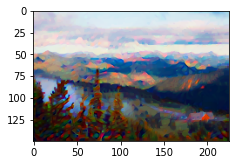

In [20]:
d2l.plt.imshow(postprocess(output));

In [21]:
image_shape = (300, 450)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output), image_shape).to(device)
big_output = train(X, content_Y, style_Y, device, 0.01, 500, 200)

training on  cuda
epoch  50, content loss 0.34, style loss 0.63, TV loss 0.79, 0.15 sec
epoch 100, content loss 0.30, style loss 0.50, TV loss 0.74, 0.15 sec
epoch 150, content loss 0.29, style loss 0.45, TV loss 0.72, 0.14 sec
epoch 200, content loss 0.28, style loss 0.43, TV loss 0.70, 0.15 sec
epoch 250, content loss 0.28, style loss 0.43, TV loss 0.70, 0.15 sec
epoch 300, content loss 0.28, style loss 0.42, TV loss 0.69, 0.14 sec
epoch 350, content loss 0.28, style loss 0.42, TV loss 0.69, 0.14 sec
epoch 400, content loss 0.27, style loss 0.42, TV loss 0.69, 0.14 sec
epoch 450, content loss 0.27, style loss 0.42, TV loss 0.69, 0.15 sec


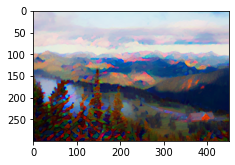

In [22]:
d2l.plt.imshow(postprocess(big_output));

### 8.12 实战Kaggle比赛：图像分类（CIFAR-10）

In [1]:
import collections
import math
import torch
import torchvision
from torch import nn
import os
import pandas as pd
import shutil
import d2lzh as d2l
data_dir = 'data/kaggle_cifar10/'

In [2]:
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))
labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 50000
# classes: 10


In [3]:
def copyfile(filename, target_dir):
    """
    将文件复制到目标路径下
    """
    # 在路径不存在的情况下创建路径
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)
def reorg_train_valid(data_dir, labels, valid_ratio):
    # 训练集中样本数最少的类别包含的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每一类的样本数
    n_valid_per_label = max(1, math.floor(n*valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train', 'train')):
        # 为每个训练集样本匹配类别
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', 'train', train_file)
        # 以类别名为文件夹名称保存数据
        # 训练集与验证集合并
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label]<n_valid_per_label:
            # 仅包含验证集
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # 仅包含训练集
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

In [4]:
def reorg_test(data_dir):
    # 测试集数据整理，类别名为unknown
    for test_file in os.listdir(os.path.join(data_dir, 'test', 'test')):
        copyfile(os.path.join(data_dir, 'test', 'test', test_file), 
                os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [5]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [6]:
batch_size = 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [7]:
transform_train = torchvision.transforms.Compose([
    # 将图像放大成高和宽各为40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机对高和宽各为40像素的正方形图像裁剪出面积为原图像面积0.64~1倍的小正方形
    # 再放缩为高和宽各为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)), 
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor(), 
    # 对图像的每个通道做标准化
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [8]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder), 
    transform=transform_train) for folder in ['train', 'train_valid']
]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder), 
    transform=transform_test) for folder in ['valid', 'test']
]

In [9]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, train_valid_ds)
]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [10]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net
net = get_net()
loss = nn.CrossEntropyLoss()

In [11]:
device, num_epochs, lr, wd = 'cuda', 5, 0.1, 5e-4
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
d2l.train(train_iter, valid_iter, net, loss, optimizer, device, num_epochs)

Let's use 2 GPUs!
training on cuda
epoch 1, loss 1.7174, train acc 0.378, test acc 0.463, time 74.0 sec
epoch 2, loss 0.6811, train acc 0.509, test acc 0.564, time 67.1 sec
epoch 3, loss 0.3951, train acc 0.580, test acc 0.588, time 67.5 sec
epoch 4, loss 0.2688, train acc 0.623, test acc 0.616, time 68.1 sec
epoch 5, loss 0.2009, train acc 0.649, test acc 0.642, time 67.5 sec


In [12]:
preds = []
for X, _ in test_iter:
    y_hat = net(X.to(device))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds)+1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

### 8.13 实战Kaggle比赛：狗的品种识别（ImageNet Dogs）

In [20]:
import d2lzh as d2l
import torch
import torchvision
from torch import nn
import os
import numpy as np
data_dir = 'data/kaggle_dogs/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    # 读取训练数据标签
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    # 整理训练数据集
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    # 整理测试数据集
    d2l.reorg_test(data_dir)
batch_size = 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [4]:
transform_train = torchvision.transforms.Compose([
    # 随机对图像裁剪出面积为原图像面积0.08~1倍、且高和宽之比在3/4~4/3的图像
    # 再放缩为高和宽均为224像素的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)), 
    torchvision.transforms.RandomHorizontalFlip(), 
    # 随机变化亮度、对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
    torchvision.transforms.ToTensor(), 
    # 对图像的每个通道做标准化
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256), 
    # 将图像中央的高和宽均为224的正方形区域裁剪出来
    torchvision.transforms.CenterCrop(224), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder), 
    transform=transform_train) for folder in ['train', 'train_valid']
]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder), 
    transform=transform_test) for folder in ['valid', 'test']
]

In [7]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, train_valid_ds)
]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [9]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # 定义新的输出网络
    # 120是输出的类别个数
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), 
                                           nn.ReLU(), 
                                           nn.Linear(256, 120))
    # 把模型参数分配到内存或显存上
    finetune_net = finetune_net.to(devices)
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [12]:
loss = nn.CrossEntropyLoss()
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices), labels.to(devices)
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum = l.sum()
        n += labels.numel()
    return l_sum/n

In [13]:
devices, num_epochs, lr, wd = device, 5, 0.01, 1e-4
net = get_net(devices)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
d2l.train(train_iter, valid_iter, net, loss, optimizer, device, num_epochs)

Let's use 2 GPUs!
training on cuda
epoch 1, loss 2.8775, train acc 0.351, test acc 0.680, time 227.9 sec
epoch 2, loss 0.7222, train acc 0.605, test acc 0.727, time 218.0 sec
epoch 3, loss 0.4139, train acc 0.657, test acc 0.769, time 208.6 sec
epoch 4, loss 0.2969, train acc 0.668, test acc 0.787, time 218.9 sec
epoch 5, loss 0.2304, train acc 0.679, test acc 0.783, time 210.7 sec


In [35]:
preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(device)), dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')
))

In [37]:
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ','.join(
            [str(num) for num in output]) + '\n'
        )